In [28]:
import os
import time
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from PIL import Image
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader 

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.transforms import Resize, Normalize
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import boto3

In [29]:
#random seed setting
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [30]:
# data directories initiation
train_data_dir = os.path.join(os.curdir,'..','..','data','preprocessed','classification','train')
val_data_dir = os.path.join(os.curdir,'..','..','data','preprocessed','classification','test')
weights_path = os.path.join(os.curdir,'..','..','models','Autoencoder-weights','resnet34.pt')
ultimate_weights = os.path.join(os.curdir,'exp10','AEpretrained_resnet34_weights.pt')

In [31]:
#convolutional block defination
class ConvBlock(nn.Module):
    def __init__(self, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.Conv2d(**kwargs),
                nn.BatchNorm2d(num_features=kwargs['out_channels']),       
        )
        
    def forward(self,x):
        return self.block(x)
        

In [32]:
#residual block defination
class ResBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride = 1,downsample = False):
        super(ResBlock,self).__init__()
        
        self.block1 = ConvBlock(in_channels= in_channels,out_channels= out_channels, stride= stride,
                                kernel_size=3, padding = 1, bias= False)
        self.block2 = ConvBlock(in_channels= out_channels,out_channels= out_channels, stride= 1,
                               kernel_size= 3,padding = 1, bias = False)
        
        self.relu = nn.ReLU(inplace=True)
        
        if downsample:
            self.downsample = ConvBlock(in_channels=in_channels,out_channels= out_channels,
                                        kernel_size= 1, stride= 2, bias= False )
        else:
            self.downsample = None
        
        
        
        
    def forward(self, x):
        identity = x
        x = self.block1(x)
        x = self.relu(x)
        x = self.block2(x)
        
        if self.downsample != None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)
        
        return x

In [33]:
#ResNet Architecture Defination
class AEResnet(nn.Module):
    def __init__(self, output_dim=2, res34=False,):
        super(AEResnet,self).__init__()
        
        self.output_dim = output_dim
        self.res34 = res34
        self.same_layer = nn.MaxPool2d(kernel_size=1,stride=1)
        
        
        
        self.conv1 = ConvBlock(in_channels= 3, out_channels= 64, kernel_size= 7,
                        stride= 2, padding= 3, bias= False) 

        self.max_pool = nn.MaxPool2d(kernel_size= 3, stride= 2, padding=1)
        self.relu = nn.ReLU(inplace= True)
        
        
        self.conv2_x = nn.Sequential(
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False),
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False),
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False) 
                        if self.res34 else self.same_layer
        
        ) 
        self.conv3_x = nn.Sequential(
                ResBlock(in_channels=64, out_channels=128, stride=2, downsample=True),
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False),
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
        )
        
        self.conv4_x = nn.Sequential(
                ResBlock(in_channels=128, out_channels=256, stride=2, downsample=True),
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False),
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
        )

        self.conv5_x = nn.Sequential(
                ResBlock(in_channels=256, out_channels=512, stride=2, downsample=True),
                ResBlock(in_channels=512, out_channels=512, stride=1, downsample=False),
                ResBlock(in_channels=512, out_channels=512, stride=1, downsample=False) 
                        if self.res34 else self.same_layer
        
        ) 
               
        

        
        self.avg_pooling = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(512,self.output_dim)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pooling(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

In [34]:
#defining the pretrained model
model = AEResnet(res34=True,output_dim=4)

In [35]:
# Auto encoder data loading
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')),strict = False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['block6.0.block.0.weight', 'block6.0.block.0.bias', 'block6.0.block.1.weight', 'block6.0.block.1.bias', 'block6.0.block.1.running_mean', 'block6.0.block.1.running_var', 'block6.0.block.1.num_batches_tracked', 'block6.1.block.0.weight', 'block6.1.block.0.bias', 'block6.1.block.1.weight', 'block6.1.block.1.bias', 'block6.1.block.1.running_mean', 'block6.1.block.1.running_var', 'block6.1.block.1.num_batches_tracked', 'block6.2.block.0.weight', 'block6.2.block.0.bias', 'block6.2.block.1.weight', 'block6.2.block.1.bias', 'block6.2.block.1.running_mean', 'block6.2.block.1.running_var', 'block6.2.block.1.num_batches_tracked', 'block6.3.block.0.weight', 'block6.3.block.0.bias', 'block6.3.block.1.weight', 'block6.3.block.1.bias', 'block6.3.block.1.running_mean', 'block6.3.block.1.running_var', 'block6.3.block.1.num_batches_tracked', 'block6.4.block.0.weight', 'block6.4.block.0.bias', 'block6.4.block.1.weight', 'block6.4.b

In [36]:
# classification layer defination
INPUT_DIM = model.fc.in_features
OUTPUT_DIM = model.fc.out_features

FC_layer = nn.Linear(INPUT_DIM,OUTPUT_DIM)
model.fc = FC_layer
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [37]:
#Weieghts freezing
for param in model.parameters():
    param.requires_grad = True

In [38]:
# parameter counting 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,286,724 trainable parameters


In [39]:
#hyperparametres and setting
lr = 0.001
batch_size = 16
epochs = 10
weight_decay=0
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
schedular = optim.lr_scheduler.StepLR(optimizer, gamma=0.5,step_size=1,verbose=True)
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Adjusting learning rate of group 0 to 1.0000e-03.


In [40]:
# related transformation defination
ROCT_MEANS = [0.20041628,0.20041628,0.20041628]
ROCT_STDEVS = [0.20288454,0.20288454,0.20288454]



transforms = Compose([
                    Resize((224,224)),
                    Lambda(lambda x: x.convert('RGB')),
                    ToTensor(),
                    Normalize(ROCT_MEANS,ROCT_STDEVS)
])


In [41]:
# Data loading and labeling
train_data = ImageFolder(root= train_data_dir,
                         transform= transforms,
                         )

val_data = ImageFolder(root= val_data_dir,
                       transform= transforms,
                       )

In [42]:
print('Train data classes: ', train_data.class_to_idx,'\n')
print('Valid. data classes: ', val_data.class_to_idx)

Train data classes:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3} 

Valid. data classes:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [43]:
#data iterator defination

train_iterator = DataLoader(train_data,
                            shuffle = True,
                            batch_size=batch_size)

val_iterator = DataLoader(val_data,
                          shuffle = True,
                          batch_size=batch_size)

In [44]:
#accuracy calculation function
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [45]:
#Epoch total time calculation
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
#training loop defination
def train(model, iterator, optimizer, criterion, device,schedular ,scaler= False):
    print('training')
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (image, label) in tqdm(iterator):
        
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        # mixed Precesion option
        if scaler:
            
            with torch.cuda.amp.autocast():     
                
                label_pred = model(image)
                loss = criterion(label_pred, label)
                assert label_pred.dtype is torch.float16
                
        else:
            label_pred = model(image)
            loss = criterion(label_pred, label)
        
        acc = calculate_accuracy(label_pred, label)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        else:
            loss.backward()
            optimizer.step()
        
    schedular.step()

        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [47]:
# Evaluation loop Defination
def evaluate(model, iterator, criterion, device):
    print('validating')
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (image, label) in tqdm(iterator):

            image = image.to(device)
            label = label.to(device)

            label_pred = model(image)

            loss = criterion(label_pred, label)

            acc = calculate_accuracy(label_pred, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [48]:
# # Model Training loop defination
# best_valid_loss = float('inf')
# model_name = 'AEpretrained_resnet34_weights'
# log = pd.DataFrame(columns=['train_loss','train_acc' ,'val_loss', 'val_acc'])

# for epoch in range(epochs):
    
#     start_time = time.monotonic()
    
#     train_loss, train_acc = train(model, train_iterator, optimizer, criterion,device,schedular,scaler=scaler)
#     val_loss, val_acc = evaluate(model, val_iterator, criterion, device)
        
#     if val_loss < best_valid_loss:
#         best_valid_loss = val_loss
#         torch.save(model.state_dict(), model_name)

#     end_time = time.monotonic()

#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     log.loc[len(log.index)] = [train_loss,train_acc,val_loss,val_acc]
#     log.to_csv('log.csv')
    
#     print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, current time: {time.ctime()}')
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')

In [49]:
#ultimate weights loading
model.load_state_dict(torch.load(ultimate_weights, map_location=torch.device('cpu')),strict = False)

<All keys matched successfully>

In [50]:
# training and validation curves plotting
training_log=  pd.read_csv(os.path.join(os.curdir,'exp10','log.csv'),index_col=0)

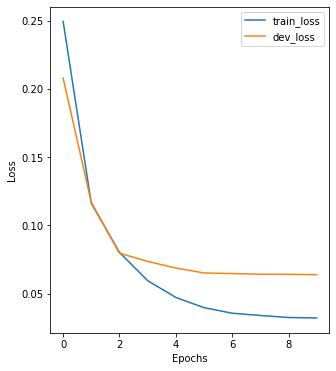

In [51]:
# loss curves
plt.figure(figsize=(5,6))
plt.plot(training_log.train_loss.to_list(), label='train_loss')
plt.plot(training_log.val_loss.to_list(), label='dev_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('aeresloss')
plt.show()

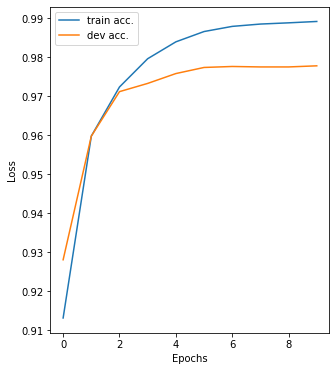

In [52]:
#accuracy curves
plt.figure(figsize=(5,6))
plt.plot(training_log.train_acc.to_list(), label='train acc.')
plt.plot(training_log.val_acc.to_list(), label='dev acc.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('aeresacc')
plt.show()

In [53]:
def get_predictions(model, iterator):

    model.eval()

    #images = []
    labels = []
    probs = []

    with torch.no_grad():

        for image, label in tqdm(iterator):

            image = image.to(device)

            label_pred = model(image)

            label_prob = F.softmax(label_pred, dim = -1)

            #images.append(image.cpu())
            labels.append(label.cpu())
            probs.append(label_prob.cpu())

    #images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    pred_labels = torch.argmax(probs, 1)

    return labels, pred_labels

In [54]:
labels, pred_labels = get_predictions(model, val_iterator)

100%|██████████| 63/63 [00:52<00:00,  1.19it/s]


In [55]:
# torch.save(labels,'labels.pt')
# torch.save(pred_labels,'pred_labels.pt')

In [56]:
conf_mat= confusion_matrix(labels,pred_labels)

<AxesSubplot:>

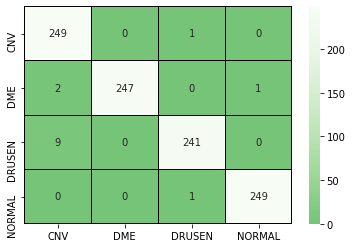

In [57]:
sns.heatmap(conf_mat,annot=True,fmt="0000.0f",
            xticklabels=['CNV','DME','DRUSEN','NORMAL'],
            yticklabels=['CNV','DME','DRUSEN','NORMAL'],
            linecolor='black',
            linewidths=0.1,
            cmap='Greens_r',
            center=0
           )

In [58]:
#Evaluation metrics calculations function

#TP, FP, FN, TN extraction function
def conf_metrics(conf_matrix, label:int):

    TP = conf_matrix[label,label]
    FP = conf_matrix[:,label].sum() - TP
    FN = conf_matrix[label,:].sum() - TP
    TN = conf_matrix.sum() - (TP+FP+FN)
    
    return TP, FP, FN, TN

In [59]:
# accuracy calculation function
def accuracy(conf_matrix):
    
    acc =  conf_matrix.diagonal().sum() / conf_matrix.sum()
    
    return round(acc * 100,2)

In [60]:
# sensitivity calculation function
def sensitivity(TP, FN):
    
    sens = TP/(TP + FN)
    
    return round(sens * 100 ,2)

In [61]:
# specificity calculation function
def specificity(TN, FP):
    
    spec = TN/(TN + FP)
    
    return round(spec * 100 ,2)

In [62]:
#performance evaluation

# CNV class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 0)
CNV_sens = sensitivity(TP,FN)
CNV_spec = specificity(TN,FP)

print(f'CNV class sensitivity: {CNV_sens}%')
print(f'CNV class specificity: {CNV_spec}%\n')


# DME class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 1)
DME_sens = sensitivity(TP,FN)
DME_spec = specificity(TN,FP)

print(f'DME class sensitivity: {DME_sens}%')
print(f'DME class specificity: {DME_spec}%\n')

# DRUSEN class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 2)
DRUSEN_sens = sensitivity(TP,FN)
DRUSEN_spec = specificity(TN,FP)

print(f'DRUSEN class sensitivity: {DRUSEN_sens}%')
print(f'DRUSEN class specificity: {DRUSEN_spec}%\n')

# NORMAL class
TP, FP, FN, TN = conf_metrics(conf_mat, label= 3)
NORMAL_sens = sensitivity(TP,FN)
NORMAL_spec = specificity(TN,FP)

print(f'NORMAL class sensitivity: {NORMAL_sens}%')
print(f'NORMAL class specificity: {NORMAL_spec}%\n')

CNV class sensitivity: 99.6%
CNV class specificity: 98.53%

DME class sensitivity: 98.8%
DME class specificity: 100.0%

DRUSEN class sensitivity: 96.4%
DRUSEN class specificity: 99.73%

NORMAL class sensitivity: 99.6%
NORMAL class specificity: 99.87%



In [63]:
#overall performance evaluation 

overall_acc = accuracy(conf_mat)
print(f'Overall accuracy {overall_acc:0.2f}%\n ')

overall_sens = np.mean([CNV_sens,DME_sens,DRUSEN_sens,NORMAL_sens])
print(f'Overall sensitivity {overall_sens:.2f}%\n ')

overall_spec = np.mean([CNV_spec,DME_spec,DRUSEN_spec,NORMAL_spec])
print(f'Overall specificity {overall_spec:.2f}%\n ')

Overall accuracy 98.60%
 
Overall sensitivity 98.60%
 
Overall specificity 99.53%
 
